[*********************100%***********************]  1 of 1 completed

C:\Users\viole\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\base.py:243: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Dividends"].fillna(0, inplace=True)
C:\Users\viole\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\base.py:244: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

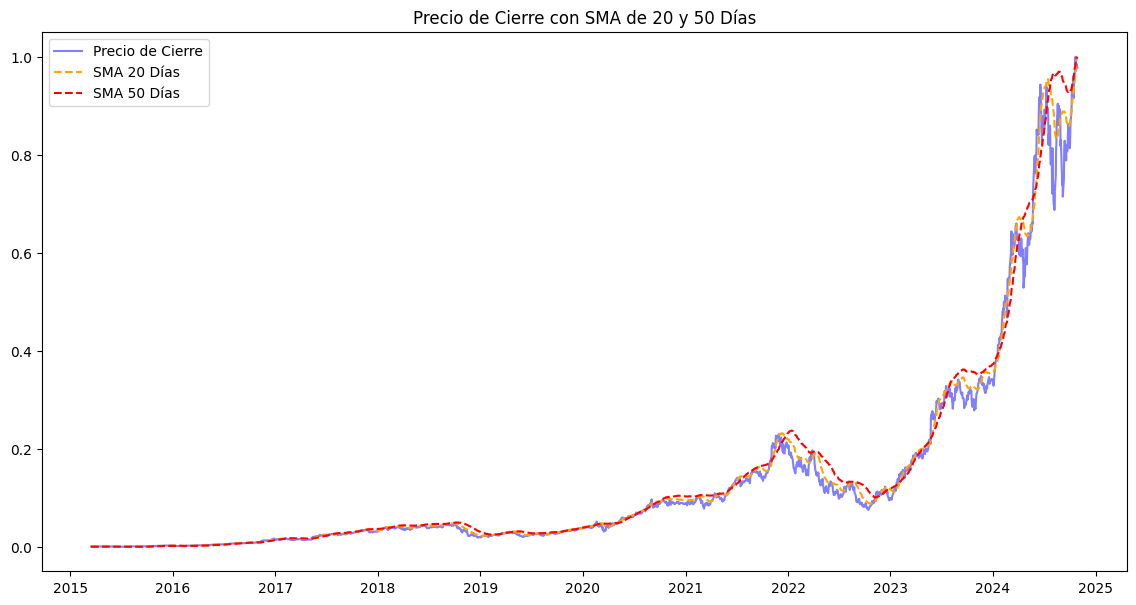

Conjunto de características (X): (2393, 30, 9)
Conjunto de etiquetas (y): (2393,)
                  Open        High         Low     Close   Adj Close  \
Date                                                                   
2024-10-22  142.910004  144.419998  141.779999  0.999162  143.589996   
2024-10-23  142.029999  142.429993  137.460007  0.971026  139.559998   
2024-10-24  140.820007  141.350006  138.460007  0.976960  140.410004   
2024-10-25  140.929993  144.130005  140.800003  0.984850  141.539993   
2024-10-28  143.000000  143.139999  140.050003  0.977728  140.520004   

               Volume    SMA_20    SMA_50       RSI  
Date                                                 
2024-10-22  226311600  0.973131  0.987053  0.811142  
2024-10-23  285930000  0.979151  0.990826  0.696425  
2024-10-24  172354900  0.985290  0.994423  0.686272  
2024-10-25  205122100  0.992844  0.997432  0.671245  
2024-10-28  173031000  1.000000  1.000000  0.591392  


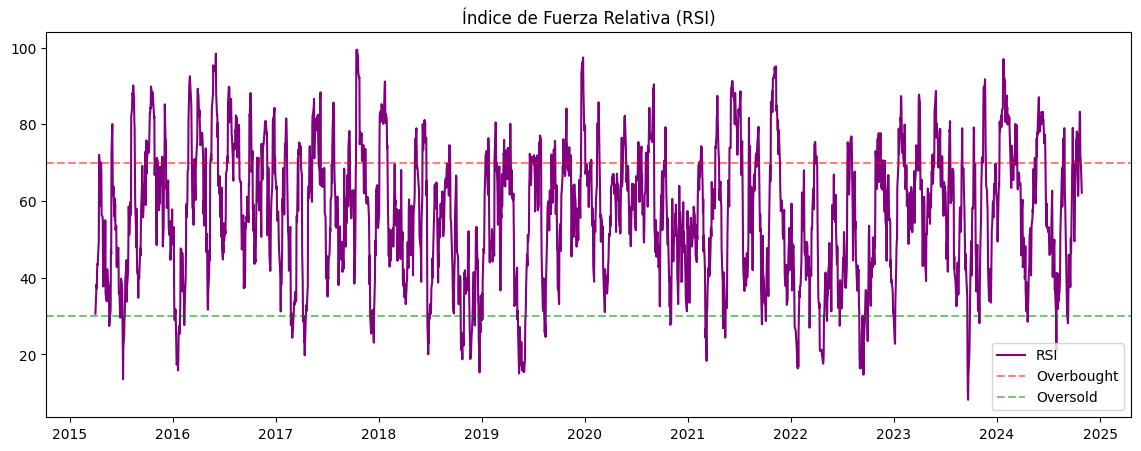

In [1]:
# Importar bibliotecas necesarias
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. RECOLECCIÓN Y CÁLCULO DE INDICADORES TÉCNICOS
# Definir el símbolo de la acción y el periodo
stock_symbol = 'NVDA'
start_date = '2015-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

# Descargar los datos históricos
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calcular el Promedio Móvil Simple (SMA) de 20 días y 50 días
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# Calcular el Índice de Fuerza Relativa (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# 2. NORMALIZACIÓN DE DATOS
# Normalización de columnas relevantes
scaler = MinMaxScaler(feature_range=(0, 1))
data[['Close', 'SMA_20', 'SMA_50', 'RSI']] = scaler.fit_transform(data[['Close', 'SMA_20', 'SMA_50', 'RSI']])

# Eliminar filas con valores nulos tras los cálculos
data.dropna(inplace=True)

# 3. CREACIÓN DE VENTANAS DE TIEMPO PARA LSTM
def create_time_windows(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i+time_step].values)
        y.append(data['Close'].iloc[i+time_step])
    return np.array(X), np.array(y)

# Crear las ventanas de tiempo para el modelo
X, y = create_time_windows(data)

# 4. VISUALIZACIÓN DE DATOS
# Visualización del precio de cierre y SMAs
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Precio de Cierre', color='blue', alpha=0.5)
plt.plot(data.index, data['SMA_20'], label='SMA 20 Días', color='orange', linestyle='--')
plt.plot(data.index, data['SMA_50'], label='SMA 50 Días', color='red', linestyle='--')
plt.title('Precio de Cierre con SMA de 20 y 50 Días')
plt.legend()
plt.show()

# Mostrar un resumen de los datos procesados y las dimensiones de las ventanas de tiempo
print(f"Conjunto de características (X): {X.shape}")
print(f"Conjunto de etiquetas (y): {y.shape}")
print(data.tail())

# Calcular el Índice de Fuerza Relativa (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Eliminar posibles valores nulos
data.dropna(subset=['RSI'], inplace=True)

# Graficar el RSI para verificar su cálculo
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label='Overbought')
plt.axhline(30, linestyle='--', color='green', alpha=0.5, label='Oversold')
plt.title('Índice de Fuerza Relativa (RSI)')
plt.legend()
plt.show()